In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from scipy.stats import randint # uniform discrete random variable

In [2]:
# Present working directory
pwd = os.getcwd()
filepath = os.path.join(pwd,"rentals.csv")
filepath

'g:\\Mi unidad\\Colab Notebooks\\House Price Regression\\rentals.csv'

In [3]:
house_df = pd.read_csv(filepath)

EDA

In [4]:
house_df.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


In [5]:
house_df.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights
count,8.111000e+03,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03
mean,2.024561e+07,37.766054,-122.430107,1.395975,1.345874,1.234526e+04
std,1.228565e+07,0.022937,0.026967,0.923213,0.925298,1.110357e+06
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08


In [6]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


<AxesSubplot:>

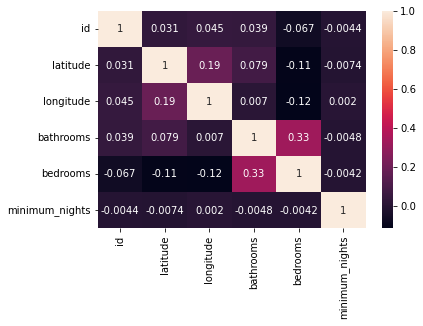

In [7]:
sns.heatmap(house_df.corr(), annot=True)

In [8]:
house_df.isnull().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

In [9]:
house_df['price'] = house_df['price'].map(lambda x: x.lstrip('$').rstrip(' ').replace(',', '')).astype(float)

<AxesSubplot:>

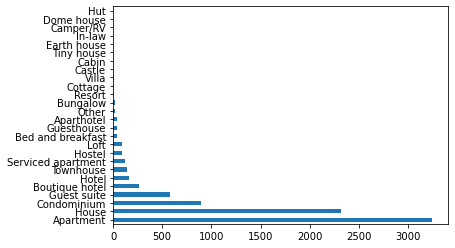

In [10]:
# Class balance
house_df["property_type"].value_counts().plot(kind="barh")

In [11]:
house_df["property_type"].value_counts()

Apartment             3243
House                 2314
Condominium            892
Guest suite            577
Boutique hotel         267
Hotel                  157
Townhouse              142
Serviced apartment     121
Hostel                  92
Loft                    88
Bed and breakfast       43
Guesthouse              41
Aparthotel              41
Other                   24
Bungalow                17
Resort                  14
Cottage                 12
Villa                   10
Castle                   4
Cabin                    3
Tiny house               3
Earth house              2
In-law                   1
Camper/RV                1
Dome house               1
Hut                      1
Name: property_type, dtype: int64

In [12]:
house_df["property_type"].replace(
    to_replace=['Castle','Cabin','Tiny house','Earth house','In-law','Camper/RV','Dome house','Hut'],
    value='Other',
    inplace=True)

## Data Cleaning

In [13]:
house_df.drop('id', axis = 1, inplace = True)
house_df

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
3,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
4,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0
...,...,...,...,...,...,...,...,...
8106,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0
8107,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0
8108,37.73410,-122.38917,Other,Private room,2.0,1.0,30,69.0
8109,37.78144,-122.41207,Apartment,Entire home/apt,1.0,1.0,30,187.0


### Outliers detection

<AxesSubplot:>

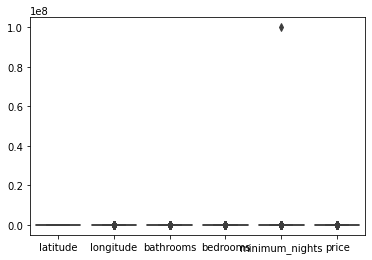

In [14]:
# Let's have a first view of the dataset in order to find out any outlier
sns.boxplot(data=house_df)

Min_nigths seems to have a lot of outliers...

Let's have a look to bathrooms and bedrooms

<AxesSubplot:>

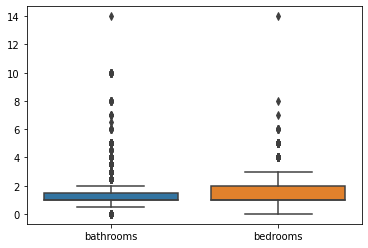

In [15]:
sns.boxplot(data=house_df[['bathrooms','bedrooms']])

In [16]:
# seems normal
house_df[house_df['bathrooms']>10]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
2386,37.78199,-122.4217,Boutique hotel,Private room,14.0,14.0,7,69.0


<AxesSubplot:>

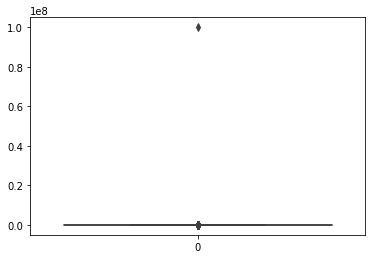

In [17]:
sns.boxplot(data=house_df['minimum_nights'])

We are goint to guess, landlords don't want to rent for more than 1 year. We can consider more than 365 are errors.
1. First we create a df(filtered_df) by removing outliers with the percentile.
2. We directly drop them.

#### 1. Outliers: Percentile

In [18]:
house_df[house_df["minimum_nights"]>365]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
1893,37.76264,-122.42082,Apartment,Private room,2.0,1.0,1125,3200.0
2912,37.75071,-122.42521,Apartment,Private room,1.0,1.0,100000000,68.0
3664,37.79305,-122.42482,Condominium,Entire home/apt,1.0,1.0,1000,150.0


In [19]:
# people to rent out their properties for short stays.
# Removing outliers
cols = ['minimum_nights','price'] # The columns you want to search for outliers in

# Calculate quantiles and IQR
Q1 = house_df[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = house_df[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((house_df[cols] < (Q1 - 1.5 * IQR)) | (house_df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_df = house_df[condition]

C:\Users\Luis Andres\miniconda3\envs\hands_on_ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

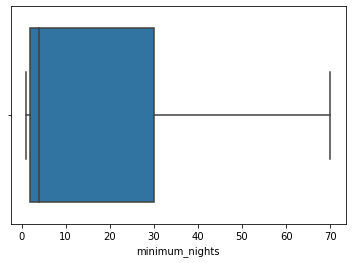

In [20]:
sns.boxplot(filtered_df["minimum_nights"])

C:\Users\Luis Andres\miniconda3\envs\hands_on_ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

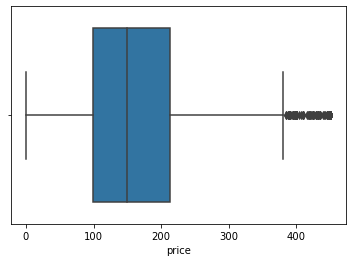

In [21]:
sns.boxplot(filtered_df["price"])

<AxesSubplot:>

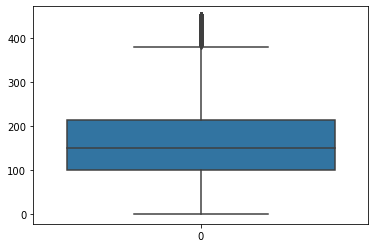

In [22]:
sns.boxplot(data=filtered_df['price'])

In [23]:
# Let's see who ask so much money for its property by night
filtered_df[filtered_df['price']>3000]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price


<AxesSubplot:>

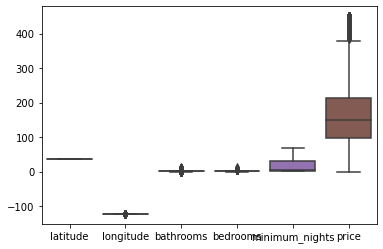

In [24]:
sns.boxplot(data=filtered_df[filtered_df['price']<3000])

#### 2. Outliers: Drop

In [25]:
house_df[house_df["minimum_nights"]>365]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
1893,37.76264,-122.42082,Apartment,Private room,2.0,1.0,1125,3200.0
2912,37.75071,-122.42521,Apartment,Private room,1.0,1.0,100000000,68.0
3664,37.79305,-122.42482,Condominium,Entire home/apt,1.0,1.0,1000,150.0


In [26]:
no_outliers_df = house_df.copy()
no_outliers_df = no_outliers_df.drop(no_outliers_df[no_outliers_df.minimum_nights > 365].index)
no_outliers_df.minimum_nights.unique()

array([  1,  30,  32,   6,   3,  90,   2,   5,   4,  60,  10, 365,  80,
        45,   7,  29,  31,   9,  14, 183, 200, 180, 120,  58, 360,  50,
        59,  70,  16,  75, 110,  13,  55, 140,  28,  85,  21,  18,  11,
       188,  40,  65, 100,  12,  38,   8,  25,  15, 150,  33], dtype=int64)

In [27]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8111 non-null   float64
 1   longitude       8111 non-null   float64
 2   property_type   8111 non-null   object 
 3   room_type       8111 non-null   object 
 4   bathrooms       8099 non-null   float64
 5   bedrooms        8107 non-null   float64
 6   minimum_nights  8111 non-null   int64  
 7   price           8111 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 507.1+ KB


In [28]:
no_outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8108 entries, 0 to 8110
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8108 non-null   float64
 1   longitude       8108 non-null   float64
 2   property_type   8108 non-null   object 
 3   room_type       8108 non-null   object 
 4   bathrooms       8096 non-null   float64
 5   bedrooms        8104 non-null   float64
 6   minimum_nights  8108 non-null   int64  
 7   price           8108 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 570.1+ KB


In [29]:
house_df["minimum_nights"].unique()

array([        1,        30,        32,         6,         3,        90,
               2,         5,         4,        60,        10,       365,
              80,        45,         7,        29,        31,         9,
              14,       183,       200,       180,       120,        58,
             360,        50,        59,        70,        16,        75,
             110,        13,        55,       140,        28,      1125,
              85,        21,        18, 100000000,        11,       188,
            1000,        40,        65,       100,        12,        38,
               8,        25,        15,       150,        33], dtype=int64)

In [30]:
no_outliers_df["minimum_nights"].unique()

array([  1,  30,  32,   6,   3,  90,   2,   5,   4,  60,  10, 365,  80,
        45,   7,  29,  31,   9,  14, 183, 200, 180, 120,  58, 360,  50,
        59,  70,  16,  75, 110,  13,  55, 140,  28,  85,  21,  18,  11,
       188,  40,  65, 100,  12,  38,   8,  25,  15, 150,  33], dtype=int64)

C:\Users\Luis Andres\miniconda3\envs\hands_on_ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

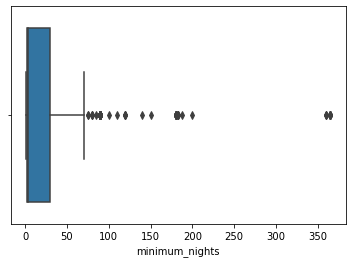

In [31]:
sns.boxplot(no_outliers_df["minimum_nights"])

In [32]:
no_outliers_df[no_outliers_df["price"] > 3000]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
57,37.76519,-122.45613,Apartment,Entire home/apt,1.0,2.0,365,9999.0
548,37.77981,-122.41022,Apartment,Shared room,1.0,1.0,58,5000.0
2818,37.74255,-122.47917,House,Private room,1.0,1.0,1,8000.0
2846,37.79866,-122.41475,Apartment,Entire home/apt,1.0,1.0,90,3250.0
4280,37.79955,-122.42823,Apartment,Entire home/apt,1.0,0.0,30,3050.0
4352,37.75903,-122.39075,Condominium,Entire home/apt,1.5,1.0,30,4500.0
5161,37.74870,-122.40936,Apartment,Entire home/apt,1.0,1.0,30,4500.0
5550,37.75388,-122.46552,Apartment,Entire home/apt,1.0,2.0,365,3800.0
7345,37.78898,-122.41659,Boutique hotel,Private room,1.0,1.0,1,10000.0
7346,37.79240,-122.42060,Boutique hotel,Private room,1.0,1.0,1,10000.0


In [33]:
no_outliers_df.drop(no_outliers_df[no_outliers_df.price > 3000].index,inplace=True)
no_outliers_df[no_outliers_df["price"] > 2000]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
956,37.73548,-122.44710,House,Entire home/apt,2.5,4.0,3,2100.0
1601,37.77832,-122.44561,Condominium,Entire home/apt,1.0,3.0,30,3000.0
3941,37.76775,-122.40801,Condominium,Entire home/apt,3.0,4.0,4,2450.0
4324,37.79376,-122.39462,House,Entire home/apt,1.0,1.0,31,2010.0
5129,37.75426,-122.42383,House,Entire home/apt,1.0,3.0,3,2500.0
5218,37.77229,-122.40395,Apartment,Private room,1.0,1.0,1,2998.0
5219,37.80608,-122.43575,Villa,Entire home/apt,5.0,6.0,3,2482.0
5367,37.76022,-122.44413,House,Entire home/apt,4.5,3.0,5,3000.0
5627,37.77172,-122.40414,Apartment,Entire home/apt,2.0,2.0,1,2999.0
5660,37.77130,-122.40272,Apartment,Private room,1.0,1.0,1,2998.0


C:\Users\Luis Andres\miniconda3\envs\hands_on_ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

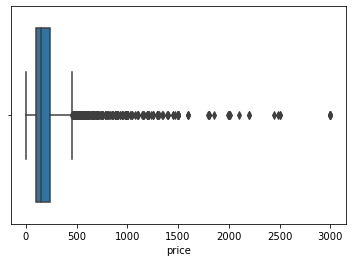

In [34]:
sns.boxplot(no_outliers_df["price"])

In [35]:
no_outliers_df[no_outliers_df["minimum_nights"]>360]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
312,37.75081,-122.44524,Apartment,Entire home/apt,1.0,1.0,365,200.0
555,37.77967,-122.40379,Loft,Entire home/apt,1.5,1.0,365,180.0
637,37.74272,-122.42144,Apartment,Entire home/apt,2.0,3.0,365,200.0
1349,37.76035,-122.39416,Apartment,Entire home/apt,2.5,3.0,365,296.0
2018,37.78818,-122.39181,Apartment,Entire home/apt,2.0,1.0,365,160.0
2479,37.78538,-122.38997,Apartment,Entire home/apt,2.0,2.0,365,202.0
4967,37.78862,-122.38892,Condominium,Entire home/apt,1.0,0.0,365,121.0


## Preprocess data

In [36]:
target = "price" # "price" is a column that we don't want in our train data

In [37]:
def split_train_test(df):
    train_set, test_set = train_test_split(df,random_state=42)
    
    # y
    train_labels = train_set[target]
    test_labels = test_set[target]

    # X 
    train = train_set.drop(target, axis = 1)
    test = test_set.drop(target, axis = 1)

    features = list(train.columns) # or test, doesn't matter, we've got the same cols
    return train_set, test_set, train_labels, test_labels, train, test, features

Pipeline

In [38]:
def preprocess(data):
  house_num = data.select_dtypes(include=[np.number])
  house_cat = data.select_dtypes(include=[object])

  # 1 step: filling NaN
  imputer = SimpleImputer(strategy="median")
  imputed = imputer.fit_transform(house_num)

  # 2 step: scale 
  scaler = StandardScaler()
  house_scaled = scaler.fit_transform(imputed)

  # 3 step: encode categ vars
  cat_encoder = OneHotEncoder(sparse=False)
  housing_cat_1hot = cat_encoder.fit_transform(house_cat) # Creates a "dense array" meaning that all instances have a value not just the ones that are encoded

  # Concatenate
  ml_input_data = np.hstack([housing_cat_1hot, house_scaled])

  return ml_input_data
  

In [39]:
train_set, test_set, train_labels, test_labels, train, test, features = split_train_test(house_df)

train_data = preprocess(train)
test_data = preprocess(test)

## Select and train a model

### Linear Regression

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(train_data, train_labels) # Fit: How train_data is related to train_labels

LinearRegression()

In [41]:
original_values = test_labels.copy()

lin_predicted_values = lin_reg.predict(test_data)

In [42]:
# Compare against some Test Data
comparison_dataframe = pd.DataFrame(data={"Original Values":original_values, "Predicted Values":lin_predicted_values})

comparison_dataframe["Differences"] = comparison_dataframe["Original Values"] - comparison_dataframe["Predicted Values"]

comparison_dataframe

,Original Values,Predicted Values,Differences
2157,168.0,287.750,-119.750
453,200.0,218.500,-18.500
8042,100.0,113.875,-13.875
5090,200.0,167.625,32.375
5365,52.0,155.375,-103.375
...,...,...,...
4231,349.0,316.125,32.875
7940,550.0,470.250,79.750
7578,125.0,145.625,-20.625
4113,252.0,392.375,-140.375


### Model selection: Linear, Tree and Random Forest Regresssor

In [43]:
models = [LinearRegression(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(n_estimators=100, random_state=42)]
model_name = ["Linear Regression", "Tree Regressor", "RF Regressor"]

In [44]:
def model_selection(train, labels, test, values):
    
    reg_model = []
    pred_model = []
    mae_model = []
    
    for name, model in zip(model_name, models):
        
        reg = model
        model.fit(train, labels)
        predictions = model.predict(test)
        score = mean_absolute_error(values, predictions)
        print("{} Mean Absolute Error: {}".format(name, score))
        reg_model.append(reg)
        pred_model.append(predictions)
        mae_model.append(score)
        
    return reg_model, pred_model, mae_model

In [45]:
model_selection(train_data, train_labels, test_data, original_values)

Linear Regression Mean Absolute Error: 117.40717455621302
Tree Regressor Mean Absolute Error: 301.5724852071006
RF Regressor Mean Absolute Error: 257.84066568047336


([LinearRegression(),
  DecisionTreeRegressor(random_state=42),
  RandomForestRegressor(random_state=42)],
 [array([287.75 , 218.5  , 113.875, ..., 145.625, 392.375, 246.625]),
  array([3800.,   90.,  120., ...,  149.,  200.,  252.]),
  array([2090.84,  185.99,   87.27, ...,  156.03,  433.06,  241.08])],
 [117.40717455621302, 301.5724852071006, 257.84066568047336])

## Cross-validation
Instead of just splitting our data into a train and test set and training once, we can do K-Fold Cross-Validation which will split our training dataset into 10 folds (sections) training on 9 of the sections and testing on the last one. It does this for all of the folds which can let us more rigorously evaluate the model.

In [46]:
# Cross Validation function
def cross_val(reg, train_data, train_labels):
    model_scores_abs = cross_val_score(reg, train_data, train_labels, scoring = "neg_mean_absolute_error", cv=10)
    scores_abs = -model_scores_abs
    
    std = scores_abs.std()
    mean = scores_abs.mean()
    
    print("{}  Standard Deviation: {} and Mean: {}".format(type(reg).__name__,std.round(),mean.round()))
    
    return std, mean

In [47]:
%%capture
lin_reg, lin_pred, lin_mae = model_selection(train_data, train_labels, test_data, original_values)[0][0], model_selection(train_data, train_labels, test_data, original_values)[1][0], model_selection(train_data, train_labels, test_data, original_values)[2][0]
tree_reg, tree_pred, tree_mae = model_selection(train_data, train_labels, test_data, original_values)[0][1], model_selection(train_data, train_labels, test_data, original_values)[1][1], model_selection(train_data, train_labels, test_data, original_values)[2][1]
forest_reg, forest_pred, forest_mae = model_selection(train_data, train_labels, test_data, original_values)[0][2], model_selection(train_data, train_labels, test_data, original_values)[1][2], model_selection(train_data, train_labels, test_data, original_values)[2][2]

In [48]:
lin_std, lin_mean = cross_val(lin_reg, train_data, train_labels)
tree_mean, tree_std = cross_val(tree_reg, train_data, train_labels)
forest_mean, forest_std = cross_val(forest_reg, train_data, train_labels)

LinearRegression  Standard Deviation: 28673.0 and Mean: 9673.0
DecisionTreeRegressor  Standard Deviation: 17.0 and Mean: 111.0
RandomForestRegressor  Standard Deviation: 17.0 and Mean: 94.0


Let's compare it with Linear Regression score

In [49]:
metrics_df = pd.DataFrame(data={"Mean Absolute Error":[lin_mae,tree_mae,forest_mae], "Mean":[lin_mean, tree_mean, forest_mean], "Std":[lin_std, tree_std, forest_std]}, 
                          index = [type(lin_reg).__name__, type(tree_reg).__name__, type(forest_reg).__name__])
metrics_df.round()

,Mean Absolute Error,Mean,Std
LinearRegression,117.0,9673.0,28673.0
DecisionTreeRegressor,302.0,17.0,111.0
RandomForestRegressor,258.0,17.0,94.0


### Fine-Tuning the Model
After picking a model (in this exercise we decide Random Forest) or set of models that are promising, we'll need to fine-tune the hyperparameters (parameters of the model that aren't affected by training) in order to find the best ones to use for our model. We can use Grid Search in order to accomplish this.

In [50]:
param_grid = [
    # Try 12 (3x4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [51]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [52]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30, random_state=42)

In [53]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

97.27104772124436 {'max_features': 2, 'n_estimators': 3}
89.805372234896 {'max_features': 2, 'n_estimators': 10}
87.14580338704968 {'max_features': 2, 'n_estimators': 30}
98.47022485728496 {'max_features': 4, 'n_estimators': 3}
91.06646080201531 {'max_features': 4, 'n_estimators': 10}
86.89383290356643 {'max_features': 4, 'n_estimators': 30}
97.78726149588914 {'max_features': 6, 'n_estimators': 3}
91.2854863348542 {'max_features': 6, 'n_estimators': 10}
87.25982992523078 {'max_features': 6, 'n_estimators': 30}
96.81780978354884 {'max_features': 8, 'n_estimators': 3}
91.10818585661463 {'max_features': 8, 'n_estimators': 10}
87.54345441812985 {'max_features': 8, 'n_estimators': 30}
89.71438128883219 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
87.93079169009211 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
93.80187318967612 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
87.99791042256165 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
9

In [54]:
pd.DataFrame(grid_search.cv_results_).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.022299,0.003044,0.0030,0.001515,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-100.642016,-97.053136,...,-97.271048,10.093996,16,-36.834566,-34.650363,-38.858405,-39.115951,-41.516540,-38.195165,2.312406
1,0.075500,0.004785,0.0055,0.000836,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-90.029745,-93.159408,...,-89.805372,6.360665,9,-34.690341,-34.228155,-36.630477,-36.772385,-36.889542,-35.842180,1.141532
2,0.205301,0.006456,0.0143,0.001502,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-86.050863,-93.324459,...,-87.145803,7.278615,2,-32.978833,-32.926099,-32.430689,-34.095754,-33.342319,-33.154739,0.552840


### Randomized Search
Randomized search allows to more easily find the hyperparameters that we're interested in because of searching through all possible combinations, it randomly picks a couple and tries those out.

In [55]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=7),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, 
                                n_iter=10, cv=5, scoring='neg_mean_absolute_error', 
                                random_state=42)

rnd_search.fit(train_data, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000206FDDC7310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000206FDDC7700>},
                   random_state=42, scoring='neg_mean_absolute_error')

In [56]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

85.76876821188219 {'max_features': 4, 'n_estimators': 93}
85.52080865277037 {'max_features': 3, 'n_estimators': 72}
88.33225532647239 {'max_features': 5, 'n_estimators': 21}
86.36565519132843 {'max_features': 2, 'n_estimators': 75}
85.57317806161204 {'max_features': 3, 'n_estimators': 88}
85.93539050371325 {'max_features': 5, 'n_estimators': 100}
85.56352276743455 {'max_features': 3, 'n_estimators': 150}
99.15189497620214 {'max_features': 5, 'n_estimators': 2}
85.48323703238286 {'max_features': 4, 'n_estimators': 158}
86.50645037976949 {'max_features': 6, 'n_estimators': 130}


In [57]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([4.81498624e-04, 7.85073038e-03, 9.54640674e-04, 5.46583239e-02,
       6.77305988e-05, 3.49113917e-03, 5.23424774e-05, 1.62512342e-03,
       1.49628039e-04, 6.41448614e-04, 5.42486852e-03, 6.50273286e-03,
       1.26655090e-03, 2.26071907e-04, 1.09859722e-03, 1.15110290e-03,
       2.90806880e-03, 8.93696017e-05, 1.32514389e-02, 3.96586776e-03,
       1.19586936e-02, 3.12671522e-03, 3.36884967e-01, 3.15391093e-01,
       5.13542687e-02, 8.16888605e-02, 9.37381267e-02])

### Feature Importance List
Judging the importance of various features is very important as this allows us to explain to our stakeholders which is most important and why which is becomeing more important as more advanced models behave like blackboxes.

In [58]:
feature_importance_list = list(zip(features,feature_importances.tolist()))
feature_importance_list

[('latitude', 0.0004814986240019756),
 ('longitude', 0.007850730379829429),
 ('property_type', 0.0009546406743468872),
 ('room_type', 0.05465832389006441),
 ('bathrooms', 6.77305987881455e-05),
 ('bedrooms', 0.003491139167221813),
 ('minimum_nights', 5.2342477382717485e-05)]

In [59]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(test_data)


final_mae = mean_absolute_error(test_labels, final_predictions)
print("Mean Absolute Error is: {}".format(final_mae))

Mean Absolute Error is: 184.58164036817882


## Same Exercice but with filtered_df

In [60]:
df2 = filtered_df.copy()

train_set_2, test_set_2, train_labels_2, test_labels_2, train_2, test_2, features_2 = split_train_test(df2)

original_values_2 = test_labels_2.copy()

train_data_2 = preprocess(train_2)
test_data_2 = preprocess(test_2)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(train_data_2, train_labels_2) # Fit: How train_data is related to train_labels

lin_predicted_values_2 = lin_reg_2.predict(test_data_2)

score_2 = mean_absolute_error(original_values_2, lin_predicted_values_2)
print("Mean Absolute Error: {}".format(score_2))

Mean Absolute Error: 47.68319138948498


I can see it has improved!!

## Same Exercice but with no_outliers_df

In [61]:
df3 = no_outliers_df.copy()

train_set_3, test_set_3, train_labels_3, test_labels_3, train_3, test_3, features_3 = split_train_test(df3)

original_values_3 = test_labels_3.copy()

train_data_3 = preprocess(train_3)
test_data_3 = preprocess(test_3)

In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7456 entries, 0 to 8110
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        7456 non-null   float64
 1   longitude       7456 non-null   float64
 2   property_type   7456 non-null   object 
 3   room_type       7456 non-null   object 
 4   bathrooms       7444 non-null   float64
 5   bedrooms        7453 non-null   float64
 6   minimum_nights  7456 non-null   int64  
 7   price           7456 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 782.3+ KB


In [63]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8091 entries, 0 to 8110
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8091 non-null   float64
 1   longitude       8091 non-null   float64
 2   property_type   8091 non-null   object 
 3   room_type       8091 non-null   object 
 4   bathrooms       8079 non-null   float64
 5   bedrooms        8087 non-null   float64
 6   minimum_nights  8091 non-null   int64  
 7   price           8091 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 568.9+ KB


In [64]:
lin_reg_3 = LinearRegression()
lin_reg_3.fit(train_data_3, train_labels_3) # Fit: How train_data is related to train_labels

lin_predicted_values_3 = lin_reg_3.predict(test_data_3)

score_3 = mean_absolute_error(original_values_3, lin_predicted_values_3)
print("Mean Absolute Error: {}".format(score_3))

Mean Absolute Error: 84.87988136431044
